# 0.0 IMPORTS

## packages

In [856]:
import os, pickle, datetime, json
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold
import itertools
from keras import models as ml
from keras import layers as l
from category_encoders.target_encoder import TargetEncoder
from pandas_profiling import ProfileReport
from scipy import stats as ss
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import sweetviz as sv
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.base                       import BaseEstimator, TransformerMixin
from skopt import gp_minimize
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression, f_classif
from xgboost import XGBClassifier




pd.options.display.max_columns = 500 # this will set limit of columns to 500
pd.set_option('display.float_format', lambda x: '%.5f' % x)

%matplotlib inline
os.getcwd()

'p:\\Python\\GitHub\\airbnb_prediction'

## 0.1 Helper Function

In [857]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [858]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [859]:
def get_metrics( ytrue, ypred):
    acc_nn = accuracy_score(ytrue, ypred)
    bacc_nn = balanced_accuracy_score(ytrue, ypred)
    kappa_nn = cohen_kappa_score(ytrue, ypred)
    print( acc_nn, "\n", bacc_nn, "\n", kappa_nn)

## 0.2 Loading Data

In [860]:
df0 = pd.read_csv("data/train_users_2.csv")
df0.columns = df0.columns.str.lower()
df0['date_account_created'] = pd.to_datetime(df0["date_account_created"])
df0 = df0[df0["date_first_booking"].notnull()]
test = df0[df0['date_account_created']>="2014-01-01"]
print( len(test) )
df0 = df0[df0['date_account_created']<"2014-01-01"]
print( len(df0) )
print( len(test)/(len(df0)+len(test)) )
df0.head(3)

29239
59669
0.3288680433706753


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.00000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.00000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.00000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [861]:
## Check classes imbalances

df0['country_destination'].value_counts(normalize=True)-test['country_destination'].value_counts(normalize=True)

US       0.00380
other   -0.01933
FR       0.00973
IT      -0.00314
GB       0.00119
ES       0.00131
CA       0.00100
DE       0.00479
NL      -0.00002
AU       0.00129
PT      -0.00059
Name: country_destination, dtype: float64

In [862]:
df_sessions = pd.read_csv( "data/sessions.csv" )
df_sessions.columns = df_sessions.columns.str.lower()
df_sessions.head(3)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.00000
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.00000
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.00000


# 1.0 Data Cleaning

In [863]:
os.makedirs( os.getcwd()+"\cleaners", exist_ok=True)

In [864]:
df1 = df0.copy()

## 1.1 Check Data Types

In [865]:
class DtypeChanger(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X,y=None):
        return self
    def transform(self, X, y=None):
        X2=X.copy()

        # CHANGE DATA TYPES
        for i in ["date_account_created", "date_first_booking"]:
            X2[i] = pd.to_datetime(X2[i])
        X2[ 'timestamp_first_active' ] = pd.to_datetime( X2['timestamp_first_active'], format="%Y%m%d%H%M%S" )
        X2['first_active'] = pd.to_datetime( X2['timestamp_first_active'].dt.strftime("%Y-%m-%d") )
        X2['age'] = X2['age'].astype("Int64")
        X2['signup_flow'] = X2['signup_flow'].astype("object")

        
        return X2

In [866]:
dtypechange = DtypeChanger()
print( df1.dtypes )
df1 = dtypechange.fit_transform( df1 )
pickle.dump(dtypechange, open(f'cleaners/1_{dtypechange.__class__.__name__}.pkl', 'wb'))
print( df1.dtypes )

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active              int64
date_first_booking                 object
gender                             object
age                               float64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object
id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 Int64
signup_method                      object
signup_flow         

## 1.2 Check Duplicates

In [867]:
class DuplicatesDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X,y=None):
        return self
    
    def transform(self, X, y=None):
        X2 = X.copy()
        X2 = X2.drop_duplicates()

        return X2

In [868]:
dropper = DuplicatesDropper()
df1 = dropper.fit_transform(df1)
pickle.dump(dropper, open(f'cleaners/2_{dropper.__class__.__name__}.pkl', 'wb'))

## 1.3 Check Outliers

In [869]:

class OutlierRemoval(BaseEstimator, TransformerMixin):
    def __init__(self, iqr_range = 1.5 , columns = None):
        assert type(columns) == list
        self.iqr_range = iqr_range
        self.columns = columns
        pass
    def fit( self, X, y=None):
        X2 = X.copy()
        self.lower = {}
        self.upper= {}

        # for i in self.columns:

            # q1 = X2[i].quantile(0.25)
            # q3 = X2[i].quantile(0.75)
            # iqr = q3 - q1
            # self.lower[f"{i}_lower"] = q1 - self.iqr_range * iqr
            # self.upper[f"{i}_upper"] = q3 + self.iqr_range * iqr
   

        return self
    
    def transform( self, X, y=None):
        X2 = X.copy()
        # for i in self.columns:
        #     X2 = X2[(X2[i] >= self.lower[f"{i}_lower"]) & (X2[i] <= self.upper[f"{i}_upper"]) | X2[i].isnull()]
        X2 = X2[((X2['age']>18) & (X2['age']<100)) | (X2['age'].isnull())]

        return X2




In [870]:
aux0 = df1.copy()
print( aux0.shape )
for i in ["age"]:
    outlier_remover = OutlierRemoval( columns=[i], iqr_range=1.8 )
    aux0 = outlier_remover.fit_transform(aux0)
    pickle.dump(outlier_remover, open(f'cleaners/3_{outlier_remover.__class__.__name__}_{i}.pkl', 'wb'))

print( aux0.shape )

(59669, 17)
(58468, 17)


## 1.4 Check Nulls

In [871]:
class NAimputer(BaseEstimator, TransformerMixin):
    def __init__(self):

        pass
    def fit(self, X,y=None):
        X2=X.copy()
        self.date_first_booking_max = X2['date_first_booking'].max().strftime( "%Y-%m-%d" )
        self.age_mean = X2['age'].mean().round()
        return self
    
    def transform(self, X, y=None):

        X2=X.copy()
        X2['age'] = X2['age'].fillna( self.age_mean ) # Fill age NaNs with the mean
        X2[X2['first_affiliate_tracked'].notnull()] # No Affiliate tracked


        return X2

In [872]:
print( df1.isnull().sum()/len(df1) )
imputer = NAimputer()
df1 = imputer.fit_transform(df1)
pickle.dump(imputer, open(f'cleaners/4_{imputer.__class__.__name__}.pkl', 'wb'))
print( df1.isnull().sum()/len(df1) )


id                        0.00000
date_account_created      0.00000
timestamp_first_active    0.00000
date_first_booking        0.00000
gender                    0.00000
age                       0.23848
signup_method             0.00000
signup_flow               0.00000
language                  0.00000
affiliate_channel         0.00000
affiliate_provider        0.00000
first_affiliate_tracked   0.02903
signup_app                0.00000
first_device_type         0.00000
first_browser             0.00000
country_destination       0.00000
first_active              0.00000
dtype: float64
id                        0.00000
date_account_created      0.00000
timestamp_first_active    0.00000
date_first_booking        0.00000
gender                    0.00000
age                       0.00000
signup_method             0.00000
signup_flow               0.00000
language                  0.00000
affiliate_channel         0.00000
affiliate_provider        0.00000
first_affiliate_tracked   0.02903

# 2.0 Feature Engineering

In [873]:
df2 = df1.copy()

## 2.1 Creature nem features

In [874]:
df2.head(2)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,first_active
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2009-06-09
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2009-10-31


In [875]:
class FeatureEngineering( TransformerMixin, BaseEstimator ):
    def __init__(self):
        pass

    def fit(self, X,y=None):
        return self
    
    def transform(self, X, y=None):
        X2 = X.copy()
        for i in ["date_account_created","first_active"]:
            X2[f"days_from_first_active_until_{i}"] = (X2[i] - X2['first_active']).apply( lambda x: x.days)

        for i in ["first_active","date_account_created"]:
            X2[f"year_{i}"] = X2[i].dt.year
            X2[f"month_{i}"] = X2[i].dt.month
            X2[f"day_{i}"] = X2[i].dt.day
            X2[f"day_of_week_{i}"] = X2[i].dt.day_of_week
            X2[f"day_of_year_first_active_{i}"] = X2[i].dt.day_of_year

        return X2



In [876]:
feature_eng = FeatureEngineering()
df2 = feature_eng.fit_transform(df2)
os.makedirs( os.getcwd()+r"\feature_engineering", exist_ok=True)
pickle.dump(feature_eng, open(f'feature_engineering/{feature_eng.__class__.__name__}.pkl', 'wb'))
df2.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,first_active,days_from_first_active_until_date_account_created,days_from_first_active_until_first_active,year_first_active,month_first_active,day_first_active,day_of_week_first_active,day_of_year_first_active_first_active,year_date_account_created,month_date_account_created,day_date_account_created,day_of_week_date_account_created,day_of_year_first_active_date_account_created
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2009-06-09,476,0,2009,6,9,1,160,2010,9,28,1,271
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2009-10-31,765,0,2009,10,31,5,304,2011,12,5,0,339
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2009-12-08,280,0,2009,12,8,1,342,2010,9,14,1,257
5,osr2jwljor,2010-01-01,2010-01-01 21:56:19,2010-01-02,-unknown-,51,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US,2010-01-01,0,0,2010,1,1,4,1,2010,1,1,4,1
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,2010-01-02,0,0,2010,1,2,5,2,2010,1,2,5,2


# 3.0 Data Filtering

In [877]:
df3 = df2.copy()

## 3.1 Filtering Rows

In [878]:
# age - greater than 15 and lower than 120 - There are few people over 120 years old
#df3 = df3[ (df3['age']>15) & (df3['age']<100) ]

# secs_elapsed - There is no possible 0 secs elapsed on website
#df3 = df3[df3['secs_elapsed']>0 ]

# 4.0 EDA

In [879]:
df4 = df3.copy()

In [880]:
jlklklkjlkjkj

NameError: name 'jlklklkjlkjkj' is not defined

## 4.1 Univariate Analysis

In [ ]:
profile = ProfileReport(df4, explorative=True)

#Saving results to a HTML file
profile.to_file("output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# remove columns with a lot of zeros ( >90%)

# aux0 = (df4==0).sum(axis=0)
# cols_zeros = (aux0/len(df4)).sort_values(ascending=False)
# cols_zeros = cols_zeros[cols_zeros>0.9]
# print( cols_zeros )
# print( df4.shape )
# df4 = df4.drop(cols_zeros.index, axis=1)
# print( df4.shape )

In [ ]:
# remove columns with almost no information ( very low cardinality )

low_card_cols = []

for i in df4.columns:
    if df4[i].value_counts(normalize=True).max()>0.85:
        low_card_cols.append(i)

print( low_card_cols )

print( df4.shape )
df4 = df4.drop( low_card_cols , axis=1 )
print( df4.shape )

['language', 'signup_app', 'days_from_first_active_until_date_account_created']
(59669, 28)
(59669, 25)


## 4.2 Bivariate Analysis


columns to drop: ['day_of_year_first_active_first_active', 'year_date_account_created', 'month_date_account_created', 'day_date_account_created', 'day_of_week_date_account_created', 'day_of_year_first_active_date_account_created']


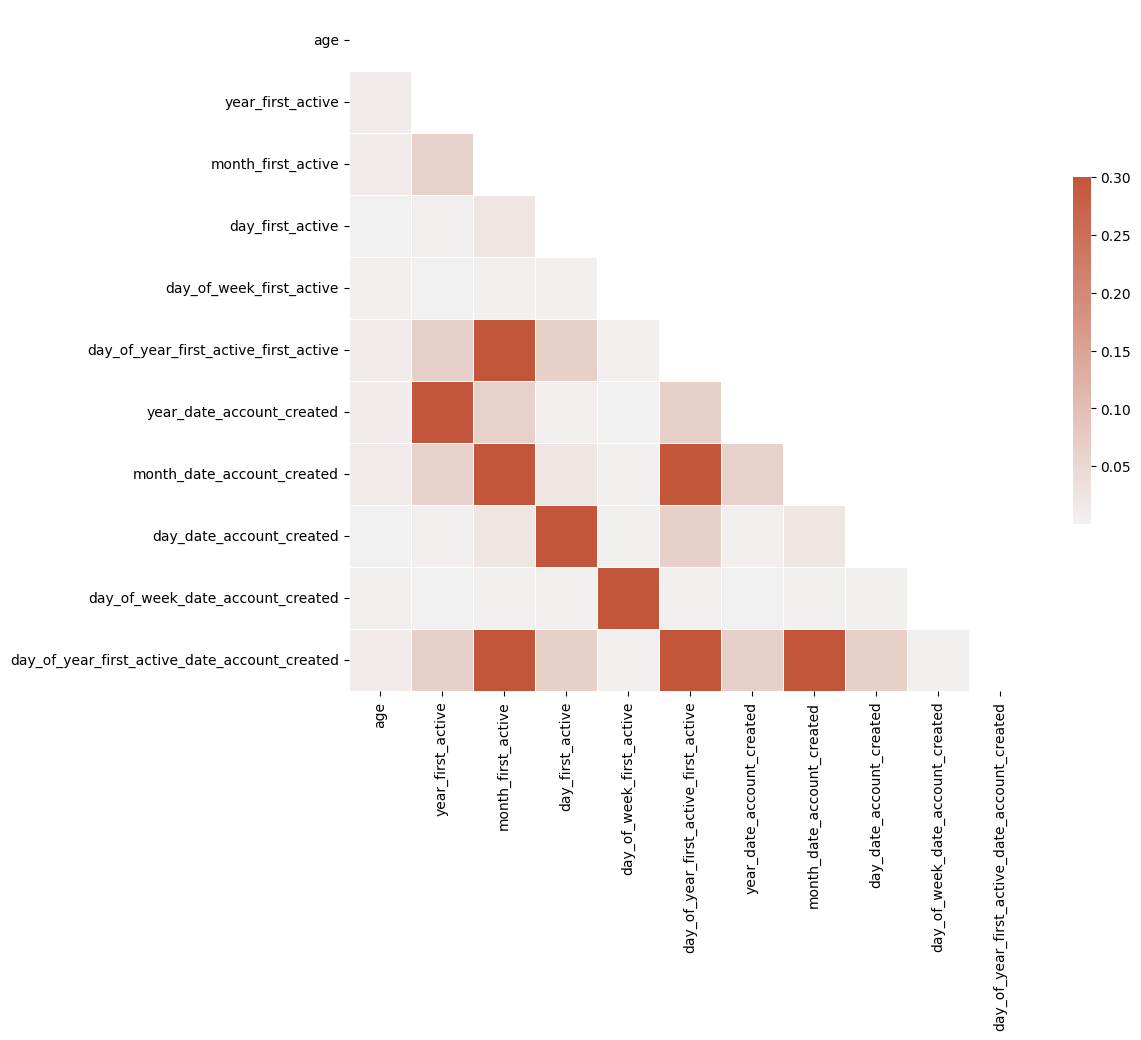

In [ ]:

# Compute the correlation matrix
corr = df4.select_dtypes(exclude=["object","datetime64[ns]"]).corr().abs()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

# Drop features 
print( f"columns to drop: {to_drop}")


In [ ]:
# only "booking" columns will be tested

to_drop2 = [x for x in to_drop if not re.search(r'first_booking', x)]
print(to_drop2)

['day_of_year_first_active_first_active', 'year_date_account_created', 'month_date_account_created', 'day_date_account_created', 'day_of_week_date_account_created', 'day_of_year_first_active_date_account_created']


<AxesSubplot: >

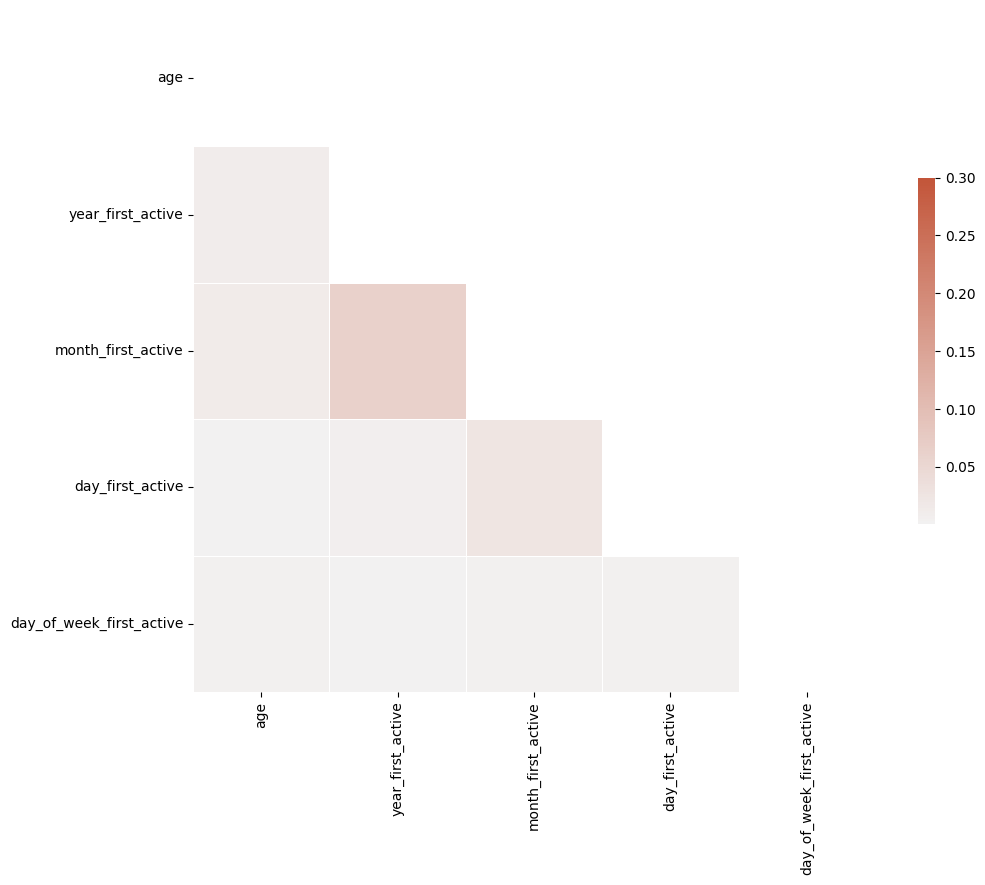

In [ ]:
df4 = df4.drop(to_drop2, axis=1)
# Compute the correlation matrix
corr2 = df4.select_dtypes(exclude=["object","datetime64[ns]"]).corr().abs()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr2, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

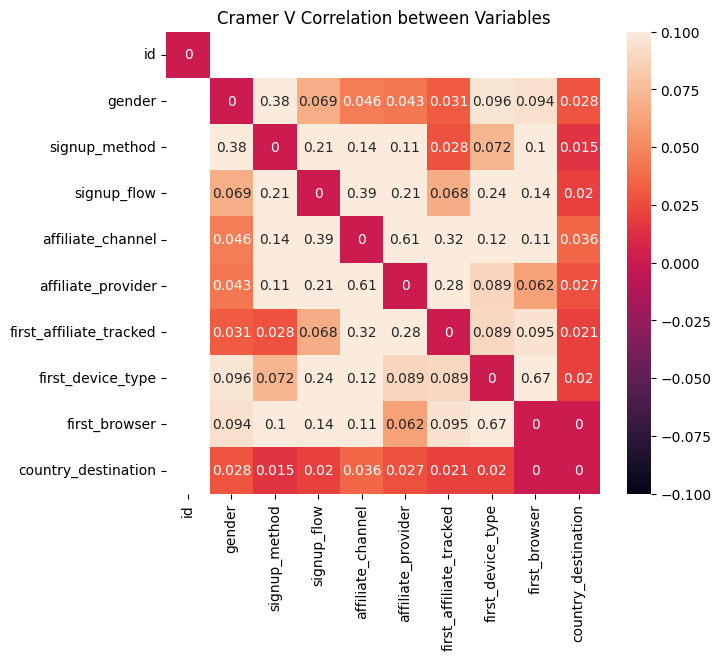

In [ ]:



cols = df4.select_dtypes(include='object').columns.tolist()
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df4[col1], df4[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");

In [ ]:
# affiliate channel is highly correlated with affiliate provider, the one with less cardinality will be kept ( In general, the same information with less cardinality is better than high's)

col_remove1= df4[['affiliate_channel', 'affiliate_provider']].nunique().idxmin()
print( col_remove1 )
df4 = df4.drop( col_remove1, axis=1 )



# affiliate first device type is highly correlated with first_browser ( In general, the same information with less cardinality is better than high's)

col_remove2 = df4[['first_device_type', 'first_browser']].nunique().idxmin()
print( col_remove2 )
df4 = df4.drop( col_remove2 , axis=1 )



affiliate_channel
first_device_type


## 4.3 Multivariate analysis - Hypoteses Validation

In [ ]:
df4.groupby("country_destination")["days_from_first_active_until_booking"].median().plot(kind='bar')

KeyError: 'Column not found: days_from_first_active_until_booking'

<AxesSubplot: xlabel='country_destination'>

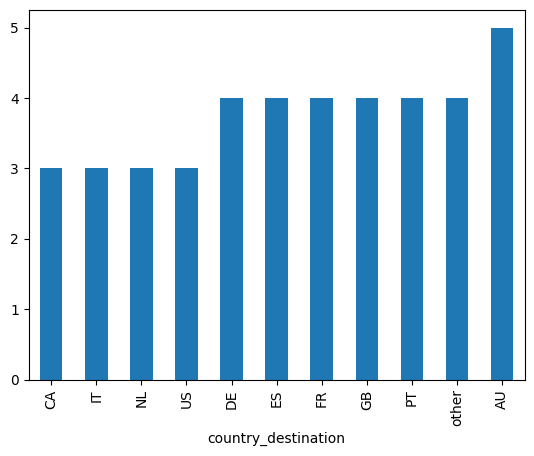

In [ ]:
df4[df4["country_destination"]!="NDF"].groupby("country_destination")["days_from_first_active_until_booking"].median().sort_values().plot(kind='bar')

<AxesSubplot: xlabel='year_first_booking'>

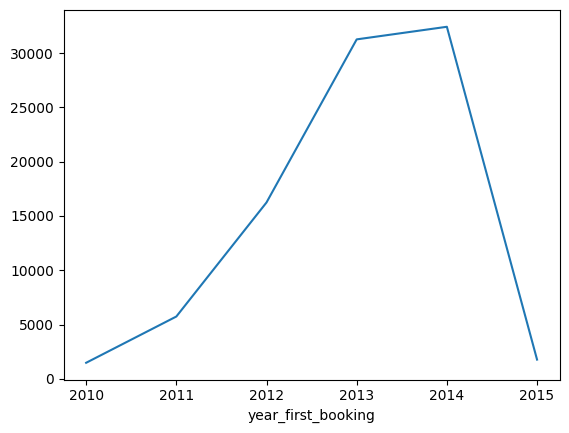

In [ ]:
df4.groupby("year_first_booking")['id'].count().sort_index().plot()

<AxesSubplot: >

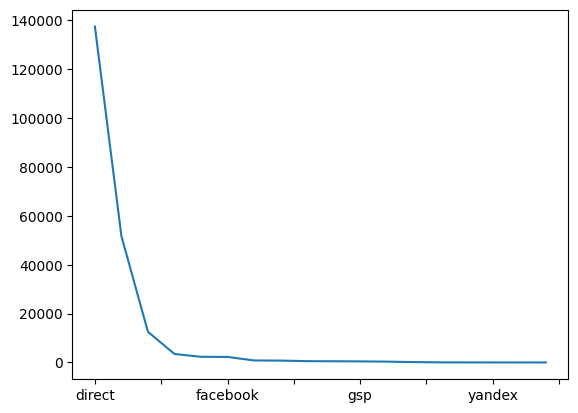

In [ ]:
df4["affiliate_provider"].value_counts().plot()

# 5.0 Data Prep

In [881]:
df5 = df4.copy()

In [882]:
os.makedirs( os.getcwd()+"\preprocessors", exist_ok=True)

In [883]:
numeric_cols = df5.select_dtypes(exclude=['object', 'datetime64[ns]']).columns
numeric_cols

Index(['age', 'days_from_first_active_until_date_account_created',
       'days_from_first_active_until_first_active', 'year_first_active',
       'month_first_active', 'day_first_active', 'day_of_week_first_active',
       'day_of_year_first_active_first_active', 'year_date_account_created',
       'month_date_account_created', 'day_date_account_created',
       'day_of_week_date_account_created',
       'day_of_year_first_active_date_account_created'],
      dtype='object')

## 5.1 Rescaling

In [884]:
# MinMax
mms = MinMaxScaler()
mms.fit_transform( df5[numeric_cols])
pickle.dump(mms, open(f'preprocessors/1_{mms.__class__.__name__}.pkl', 'wb'))

## 5.2 Encoding

In [885]:
cols_te = df5.drop(["country_destination","id"], axis=1).select_dtypes(include=['object','category']).columns.tolist()
cols_te

['gender',
 'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser']

In [886]:
df5[cols_te].nunique().sort_values()

signup_method               2
gender                      4
signup_app                  4
first_affiliate_tracked     7
affiliate_channel           8
first_device_type           9
signup_flow                16
affiliate_provider         16
language                   23
first_browser              38
dtype: int64

In [887]:
dic_countries = {}
for n,v in enumerate(df5['country_destination'].unique()):
    dic_countries[v]= n
dic_countries

{'US': 0,
 'other': 1,
 'FR': 2,
 'CA': 3,
 'GB': 4,
 'ES': 5,
 'IT': 6,
 'PT': 7,
 'NL': 8,
 'DE': 9,
 'AU': 10}

In [888]:
# for i in cols_te:
#     te = TargetEncoder()
#     df5[i]=te.fit_transform( df5[i], df5['country_destination'].map(dic_countries) )
#     pickle.dump(te, open(f'preprocessors/2_{te.__class__.__name__}_{i}.pkl', 'wb'))

In [889]:
# # create an instance of OneHotEncoder
# encoder = OneHotEncoder(sparse=False, dtype=int, handle_unknown='ignore')

# # fit and transform specified columns
# encoded_cols = encoder.fit_transform(df5[cols_ohe])

# # create dataframe from encoded data
# encoded_df = pd.DataFrame(encoded_cols, 
#        #                   columns=encoder.get_feature_names_out(cols_to_encode)
#                           )

# # concatenate original dataframe with encoded dataframe
# df5 = pd.concat([df5.drop(cols_ohe, axis=1), encoded_df], axis=1, ignore_index=True)
# df5.columns = [str(i) for i in df5.columns]
# df5.head()

# # pickle.dump( encoder, open(f"preprocessors/2_{encoder.__class__.__name__}.pkl", "wb"))

## 5.3 Nature Transformation

In [890]:

class NatureTransformation( TransformerMixin, BaseEstimator ):
   def __init__( self ):
      pass

   def fit( self, X, y=None):
      return self
   
   def transform( self, X, y=None):
      X2 = X.copy()
      # day of week
      for i in X2.filter(regex='day_of_week').columns:
         X2[f'{i}_sin'] = X2[i].apply( lambda x: np.sin( x * ( 2. * np.pi/7) ) ) 
         X2[f'{i}_cos'] = X2[i].apply( lambda x: np.cos( x * ( 2. * np.pi/7) ) ) 

      #month
      for i in X2.filter(regex='month_date').columns:
         X2[f'{i}_sin'] = X2[i].apply( lambda x: np.sin( x * ( 2. * np.pi/12) ) ) 
         X2[f'{i}_cos'] = X2[i].apply( lambda x: np.cos( x * ( 2. * np.pi/12) ) ) 

      #day of month
      for i in X2.filter(regex='day_date').columns:
         X2[f'{i}_sin'] = X2[i].apply( lambda x: np.sin( x * ( 2. * np.pi/31) ) ) 
         X2[f'{i}_cos'] = X2[i].apply( lambda x: np.cos( x * ( 2. * np.pi/31) ) ) 

      #day of year
      for i in X2.filter(regex='day_of_year').columns:
         X2[f'{i}_sin'] = X2[i].apply( lambda x: np.sin( x * ( 2. * np.pi/365) ) ) 
         X2[f'{i}_cos'] = X2[i].apply( lambda x: np.cos( x * ( 2. * np.pi/365) ) ) 

      return X2

naturetransformation = NatureTransformation()
df5 = naturetransformation.fit_transform(df5)
df5.head()


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,first_active,days_from_first_active_until_date_account_created,days_from_first_active_until_first_active,year_first_active,month_first_active,day_first_active,day_of_week_first_active,day_of_year_first_active_first_active,year_date_account_created,month_date_account_created,day_date_account_created,day_of_week_date_account_created,day_of_year_first_active_date_account_created,day_of_week_first_active_sin,day_of_week_first_active_cos,day_of_week_date_account_created_sin,day_of_week_date_account_created_cos,month_date_account_created_sin,month_date_account_created_cos,day_date_account_created_sin,day_date_account_created_cos,day_of_year_first_active_first_active_sin,day_of_year_first_active_first_active_cos,day_of_year_first_active_date_account_created_sin,day_of_year_first_active_date_account_created_cos
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2009-06-09,476,0,2009,6,9,1,160,2010,9,28,1,271,0.78183,0.62349,0.78183,0.62349,-1.00000,-0.00000,-0.57127,0.82076,0.37771,-0.92592,-0.99888,-0.04732
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2009-10-31,765,0,2009,10,31,5,304,2011,12,5,0,339,-0.97493,-0.22252,0.00000,1.00000,-0.00000,1.00000,0.84864,0.52896,-0.86746,0.49751,-0.43278,0.90150
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2009-12-08,280,0,2009,12,8,1,342,2010,9,14,1,257,0.78183,0.62349,0.78183,0.62349,-1.00000,-0.00000,0.29936,-0.95414,-0.38566,0.92264,-0.95872,-0.28436
5,osr2jwljor,2010-01-01,2010-01-01 21:56:19,2010-01-02,-unknown-,51,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US,2010-01-01,0,0,2010,1,1,4,1,2010,1,1,4,1,-0.43388,-0.90097,-0.43388,-0.90097,0.50000,0.86603,0.20130,0.97953,0.01721,0.99985,0.01721,0.99985
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,2010-01-02,0,0,2010,1,2,5,2,2010,1,2,5,2,-0.97493,-0.22252,-0.97493,-0.22252,0.50000,0.86603,0.39436,0.91896,0.03442,0.99941,0.03442,0.99941


In [891]:
pickle.dump( naturetransformation, open(f"{os.getcwd()}/preprocessors/3_{naturetransformation.__class__.__name__}.pkl", "wb") )

# 6.0 Feature Selection

In [907]:
df6 = df5.copy()

In [908]:
df5.head(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,first_active,days_from_first_active_until_date_account_created,days_from_first_active_until_first_active,year_first_active,month_first_active,day_first_active,day_of_week_first_active,day_of_year_first_active_first_active,year_date_account_created,month_date_account_created,day_date_account_created,day_of_week_date_account_created,day_of_year_first_active_date_account_created,day_of_week_first_active_sin,day_of_week_first_active_cos,day_of_week_date_account_created_sin,day_of_week_date_account_created_cos,month_date_account_created_sin,month_date_account_created_cos,day_date_account_created_sin,day_date_account_created_cos,day_of_year_first_active_first_active_sin,day_of_year_first_active_first_active_cos,day_of_year_first_active_date_account_created_sin,day_of_year_first_active_date_account_created_cos
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2009-06-09,476,0,2009,6,9,1,160,2010,9,28,1,271,0.78183,0.62349,0.78183,0.62349,-1.00000,-0.00000,-0.57127,0.82076,0.37771,-0.92592,-0.99888,-0.04732
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2009-10-31,765,0,2009,10,31,5,304,2011,12,5,0,339,-0.97493,-0.22252,0.00000,1.00000,-0.00000,1.00000,0.84864,0.52896,-0.86746,0.49751,-0.43278,0.90150
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2009-12-08,280,0,2009,12,8,1,342,2010,9,14,1,257,0.78183,0.62349,0.78183,0.62349,-1.00000,-0.00000,0.29936,-0.95414,-0.38566,0.92264,-0.95872,-0.28436


In [909]:
dic_countries

{'US': 0,
 'other': 1,
 'FR': 2,
 'CA': 3,
 'GB': 4,
 'ES': 5,
 'IT': 6,
 'PT': 7,
 'NL': 8,
 'DE': 9,
 'AU': 10}

In [924]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df6.select_dtypes(include=numerics).columns

Index(['age', 'days_from_first_active_until_date_account_created',
       'days_from_first_active_until_first_active', 'year_first_active',
       'month_first_active', 'day_first_active', 'day_of_week_first_active',
       'day_of_year_first_active_first_active', 'year_date_account_created',
       'month_date_account_created', 'day_date_account_created',
       'day_of_week_date_account_created',
       'day_of_year_first_active_date_account_created',
       'day_of_week_first_active_sin', 'day_of_week_first_active_cos',
       'day_of_week_date_account_created_sin',
       'day_of_week_date_account_created_cos',
       'month_date_account_created_sin', 'month_date_account_created_cos',
       'day_date_account_created_sin', 'day_date_account_created_cos',
       'day_of_year_first_active_first_active_sin',
       'day_of_year_first_active_first_active_cos',
       'day_of_year_first_active_date_account_created_sin',
       'day_of_year_first_active_date_account_created_cos'],
      

In [925]:
X = df6[['age', 'days_from_first_active_until_date_account_created',
       'days_from_first_active_until_first_active', 'year_first_active',
       'month_first_active', 'day_first_active', 'day_of_week_first_active',
       'day_of_year_first_active_first_active', 'year_date_account_created',
       'month_date_account_created', 'day_date_account_created',
       'day_of_week_date_account_created',
       'day_of_year_first_active_date_account_created',
       'day_of_week_first_active_sin', 'day_of_week_first_active_cos',
       'day_of_week_date_account_created_sin',
       'day_of_week_date_account_created_cos',
       'month_date_account_created_sin', 'month_date_account_created_cos',
       'day_date_account_created_sin', 'day_date_account_created_cos',
       'day_of_year_first_active_first_active_sin',
       'day_of_year_first_active_first_active_cos',
       'day_of_year_first_active_date_account_created_sin',
       'day_of_year_first_active_date_account_created_cos']]
y = df6['country_destination'].map(dic_countries).copy()
Xtrain, Xval, ytrain, yval = train_test_split( X, y, test_size = 0.3, random_state=42, stratify=y )
y.head(3)

2    0
3    1
4    0
Name: country_destination, dtype: int64

In [926]:
class FeatureSelection( BaseEstimator, TransformerMixin ):
    def __init__(self, columns=None):
        self.columns = columns
        pass
    def fit( self, X, y=None):
        return X
    def transform( self, X, y=None):
        X2 = X.copy()
        X2 = X2.drop(self.columns, axis=1)

In [927]:
df6.isnull().sum()/len(df6)

id                                                  0.00000
date_account_created                                0.00000
timestamp_first_active                              0.00000
date_first_booking                                  0.00000
gender                                              0.00000
age                                                 0.00000
signup_method                                       0.00000
signup_flow                                         0.00000
language                                            0.00000
affiliate_channel                                   0.00000
affiliate_provider                                  0.00000
first_affiliate_tracked                             0.02903
signup_app                                          0.00000
first_device_type                                   0.00000
first_browser                                       0.00000
country_destination                                 0.00000
first_active                            

In [929]:

selector = SelectKBest(score_func=f_classif, k=10)

Xtrain2 = selector.fit_transform( Xtrain, ytrain )
Xval2 = selector.transform( Xval )

mdl = RandomForestClassifier( n_estimators=100, n_jobs=-1, random_state=42 )
mdl.fit(Xtrain2, ytrain)

p = mdl.predict( Xval2 )

get_metrics( yval, p)

p:\Python\GitHub\airbnb_prediction\env_airbnb\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [2] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)


0.7028098988883302 
 0.09090909090909091 
 0.00011194408062453753


# 7.0 Machine Learning Model

In [ ]:
df7 = df6.copy()

## 7.1 Baseline Model

In [ ]:
country_list = np.sort(y.unique())
country_list

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [ ]:
weights_country = y.value_counts(normalize=True).sort_index()
weights_country

0    0.58347
1    0.29223
2    0.04729
3    0.02353
4    0.00669
5    0.01089
6    0.01054
7    0.01328
8    0.00102
9    0.00357
10   0.00497
11   0.00253
Name: country_destination, dtype: float64

In [ ]:
yhat_random = random.choices( population=country_list, weights=weights_country ,k=len(Xtest))

In [ ]:
# accuracy

acc_nn = accuracy_score(ytest, yhat_random)

bacc_nn = balanced_accuracy_score(ytest, yhat_random)

kappa_nn = cohen_kappa_score(ytest, yhat_random)

print( acc_nn, "\n", bacc_nn, "\n", kappa_nn)


0.42774376912986445 
 0.08080222308123168 
 -0.0038391895181926206


Confusion matrix, without normalization
[[21833 10886  1749   892   243   416   390   527    31   129   181    86]
 [11003  5369   887   433   115   202   203   272    20    64    94    51]
 [ 1784   887   140    65    23    32    30    34     1    10    15     7]
 [  859   446    84    30    15    14    16    20     1     7     9     6]
 [  254   131    15     7     1     6     2     7     0     1     2     2]
 [  405   210    30    20     8     5     5     6     0     5     3     0]
 [  401   191    30    13     9    10     1     9     1     2     6     2]
 [  524   223    40    24     6     5     9     9     2     1     8     0]
 [   32    22     3     5     0     0     0     1     0     0     2     0]
 [  139    70     5     1     1     5     3     1     1     1     1     1]
 [  200    84    13     6     3     2     1     4     1     1     2     1]
 [   90    55     4     3     5     1     1     1     1     1     0     0]]


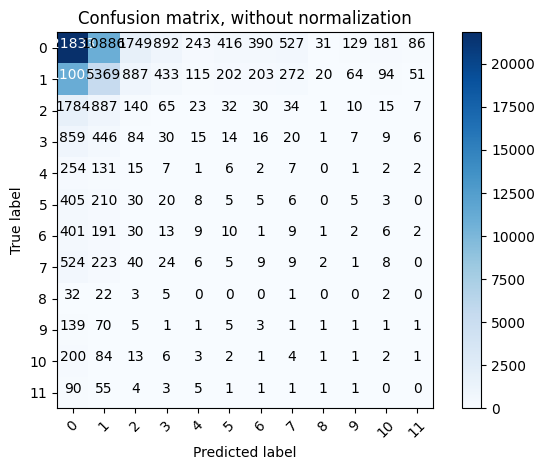

In [ ]:
cnf_matrix = confusion_matrix(ytest, yhat_random,labels=y.unique())
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=y.unique(),
                      title='Confusion matrix, without normalization')

## 7.2 Xgboost classifier


In [ ]:


xgb = XGBClassifier(n_estimators=100, random_state=42, max_depth=10)

xgb.fit(Xtrain, ytrain)

# prediction
pred_xgb = xgb.predict( Xtest )

get_metrics( ytest, pred_xgb )

0.8730713973389969 
 0.16800850014656502 
 0.7646449567232468


## 7.3 CatboostClassifier

In [ ]:

catmodel = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1')
catmodel.fit(Xtrain, ytrain, verbose=False)

In [ ]:
# prediction
pred_catmodel = catmodel.predict( Xtest )

get_metrics( ytest, pred_catmodel )

0.8749141108126679 
 0.16707520656004002 
 0.7676453626162763


## 7.4 LightGBMClassifier

In [ ]:


lgbm = LGBMClassifier( n_estimators = 50, random_state=42)
lgbm.fit(Xtrain, ytrain, verbose=False)

p:\Python\GitHub\airbnb_prediction\env_airbnb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: age

: 

In [ ]:
# prediction
pred_lgbm = lgbm.predict( Xtest )

get_metrics( ytest, pred_lgbm )

NotFittedError: Estimator not fitted, call fit before exploiting the model.

## 7.5 Random Forest Classifier

In [ ]:
rf = RandomForestClassifier( n_estimators = 200, random_state=42)
rf.fit(Xtrain, ytrain)

RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
# prediction
pred_rf = rf.predict( Xtest )

get_metrics( ytest, pred_rf )

0.8649643937176861 
 0.16661179355616076 
 0.7512357566843145


## 8.0 Hyperparameter Tuning

In [ ]:
from skopt import dummy_minimize
?dummy_minimize

Signature:
dummy_minimize(
    func,
    dimensions,
    n_calls=100,
    initial_point_generator='random',
    x0=None,
    y0=None,
    random_state=None,
    verbose=False,
    callback=None,
    model_queue_size=None,
    init_point_gen_kwargs=None,
)
Docstring:
Random search by uniform sampling within the given bounds.

Parameters
----------
func : callable
    Function to minimize. Should take a single list of parameters
    and return the objective value.

    If you have a search-space where all dimensions have names,
    then you can use :func:`skopt.utils.use_named_args` as a decorator
    on your objective function, in order to call it directly
    with the named arguments. See `use_named_args` for an example.

dimensions : list, shape (n_dims,)
    List of search space dimensions.
    Each search dimension can be defined either as

    - a `(lower_bound, upper_bound)` tuple (for `Real` or `Integer`
      dimensions),
    - a `(lower_bound, upper_bound, prior)` tuple (for `R

In [ ]:
def treinar_modelo(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    mdl = LGBMClassifier(learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree, random_state=42, subsample_freq=1, 
                         n_estimators=100)
    mdl.fit(Xtrain, ytrain)
    
    p = mdl.predict_proba(Xtest)
    
    return -roc_auc_score(ytest, p, multi_class='ovr')

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 128), # num_leaves
         (1, 100), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0)] # colsample bytree

resultado = dummy_minimize(treinar_modelo, space, random_state=1, verbose=1, n_calls=30)

Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, 74, 10, 0.3372159440002478, 0.23208030173540176] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 19.5620
Function value obtained: -0.7470
Current minimum: -0.7470
Iteration No: 2 started. Evaluating function at random point.
[0.001529949829431263, 78, 72, 0.3782826906908954, 0.457090726807603] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 14.7770
Function value obtained: -0.8525
Current minimum: -0.8525
Iteration No: 3 started. Evaluating function at random point.
[0.01195730942971637, 128, 19, 0.5483207515942279, 0.49910760440160107] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 20.9980
Function value obtained: -0.8492
Current minimum: -0.8525
Iteration No: 4 started. Evaluating function at random point.
[0.0028784217488024557, 16, 51, 0.9182639233502714, 0.5114843271882895] 

Iteration No: 4 ended. Evaluation done at random point.
T

In [ ]:
dir(resultado)

['fun',
 'func_vals',
 'models',
 'random_state',
 'space',
 'specs',
 'x',
 'x_iters']

In [ ]:
resultado.x

[0.024010940718920456, 9, 25, 0.3814534248789504, 0.3429351025885235]

In [ ]:

lgbm = LGBMClassifier(learning_rate=resultado.x[0], num_leaves=resultado.x[1], min_child_samples=resultado.x[2],
                        subsample=resultado.x[3], colsample_bytree=resultado.x[4], random_state=42, subsample_freq=1, 
                         n_estimators=100)
lgbm.fit(Xtrain, ytrain, verbose=False)
# prediction
pred_lgbm = lgbm.predict( Xtest )
pred_proba_lgbm = lgbm.predict_proba( Xtest )
get_metrics( ytest, pred_lgbm )


p:\Python\GitHub\airbnb_prediction\env_airbnb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


0.8726953467954346 
 0.16666666666666666 
 0.7640573431952373


In [ ]:
roc_auc_score(ytest, pred_lgbmpred_proba_lgbm, multi_class="ovr")

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
# generate k-fold
num_folds = 5
kfold = StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( Xtrain, ytrain ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    Xtrain_fold = Xtrain.iloc[train_ix]
    ytrain_fold = ytrain.iloc[train_ix]
    
    x_val_fold = Xtrain.iloc[val_ix]
    y_val_fold = ytrain.iloc[val_ix]

    model = LGBMClassifier(learning_rate=resultado.x[0], num_leaves=resultado.x[1], min_child_samples=resultado.x[2],
                        subsample=resultado.x[3], colsample_bytree=resultado.x[4], random_state=42, subsample_freq=1, 
                         n_estimators=100)
    
    model.fit(Xtrain_fold, ytrain_fold, verbose=False)

    # prediction
    pred = model.predict( x_val_fold )
    

    # metrics
    ## Balanced Accuracy 
    balanced_acc = balanced_accuracy_score( y_val_fold, pred )
    balanced_acc_list.append( balanced_acc )
    
    ## Kappa Metrics
    kappa_acc = cohen_kappa_score( y_val_fold, pred )
    kappa_acc_list.append( kappa_acc )

Fold Number: 1/5


p:\Python\GitHub\airbnb_prediction\env_airbnb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold Number: 1/5


p:\Python\GitHub\airbnb_prediction\env_airbnb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold Number: 1/5


p:\Python\GitHub\airbnb_prediction\env_airbnb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold Number: 1/5


p:\Python\GitHub\airbnb_prediction\env_airbnb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold Number: 1/5


p:\Python\GitHub\airbnb_prediction\env_airbnb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [ ]:
np.mean(balanced_acc_list)

0.1666649386556074

In [ ]:
balanced_acc_list

[0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.1666580266113703,
 0.16666666666666666]

# 9.0 Business Evaluation

# 10.0 Full Pipeline

In [ ]:
import os, pickle, datetime, json
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold
import itertools
from keras import models as ml
from keras import layers as l
from category_encoders.target_encoder import TargetEncoder
from pandas_profiling import ProfileReport
from scipy import stats as ss
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import sweetviz as sv
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.base                       import BaseEstimator, TransformerMixin
from skopt import gp_minimize
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression, f_classif
from xgboost import XGBClassifier


In [ ]:
from glob import glob
import pickle

class AirbnbPrediction( TransformerMixin, BaseEstimator ):
    def __init__( self ):
        self.home_path = os.getcwd()

    def cleaner( self, X):
        X2 = X.copy()
        for i in sorted(glob(r'cleaners\*.pkl')) :
            X2 = pickle.load( open(i, "rb") ).transform(X2)
        return X2

    def feature_engineering( self, X):
        X2 = X.copy()
        for i in sorted(glob(r'feature_engineering\*.pkl')) :
            X2 = pickle.load( open(i, "rb") ).transform(X2)
        return X2
    
    def preprocessors( self, X):
        X2 = X.copy()
        for i in sorted(glob(r'preprocessors\*.pkl')) :
            transformer = pickle.load( open(i, "rb") )
            if "MinMax" in transformer.__class__.__name__:
                features = transformer.feature_names_in_.tolist()
                X2[features] = transformer.transform(X2[features])
            else:
                X2 = transformer.transform(X2)
        return X2





air = AirbnbPrediction()
aux1 = air.cleaner(test)
aux1 = air.feature_engineering(aux1)
aux1 = air.preprocessors(aux1)
aux1.head()


ValueError: Unexpected input dimension 34, expected 1

In [ ]:
aux1.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination', 'first_active',
       'days_from_first_active_until_date_first_booking',
       'days_from_first_active_until_date_account_created',
       'year_first_active', 'month_first_active', 'day_first_active',
       'day_of_week_first_active', 'day_of_year_first_active_first_active',
       'year_date_first_booking', 'month_date_first_booking',
       'day_date_first_booking', 'day_of_week_date_first_booking',
       'day_of_year_first_active_date_first_booking',
       'year_date_account_created', 'month_date_account_created',
       'day_date_account_created', 'day_of_week_date_account_created',
       'day_of_year_first_active_date_account_created'],
      dtype='object')

In [ ]:
df5.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination', 'first_active',
       'days_from_first_active_until_date_first_booking',
       'days_from_first_active_until_date_account_created',
       'year_first_active', 'month_first_active', 'day_first_active',
       'day_of_week_first_active', 'day_of_year_first_active_first_active',
       'year_date_first_booking', 'month_date_first_booking',
       'day_date_first_booking', 'day_of_week_date_first_booking',
       'day_of_year_first_active_date_first_booking',
       'year_date_account_created', 'month_date_account_created',
       'day_date_account_created', 'day_of_week_date_account_created',
       'day_of_year_first_active_date_account_created',
       'day_of_week_first

In [ ]:
aux1.shape

(75482, 34)

In [ ]:
df5.shape

(213451, 54)

In [ ]:
aux1.shape

(75482, 17)

In [ ]:
from glob import glob
cleaners = sorted([os.path.basename(x) for x in glob(r'cleaners\*.pkl')])
cleaners

TypeError: bad operand type for unary -: 'list'

In [ ]:
for i in 